BP-NeuralNetwork training begins
epoch=0, erro=0.18552979318514964, acc=0.8583333333333333
epoch=1, erro=0.12847946017398604, acc=0.9083333333333333
epoch=2, erro=0.11065098582835302, acc=0.9583333333333334
BP-NeuralNetwork training end


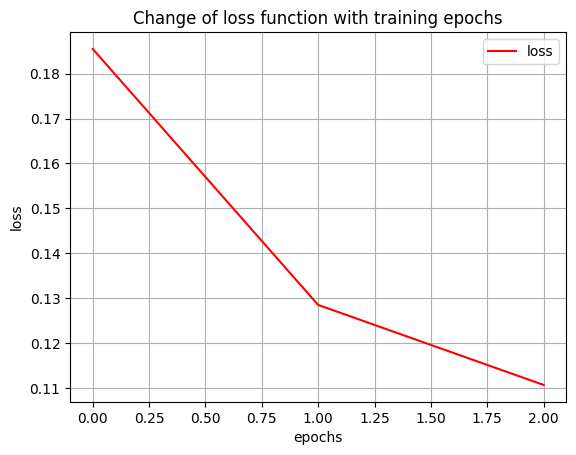

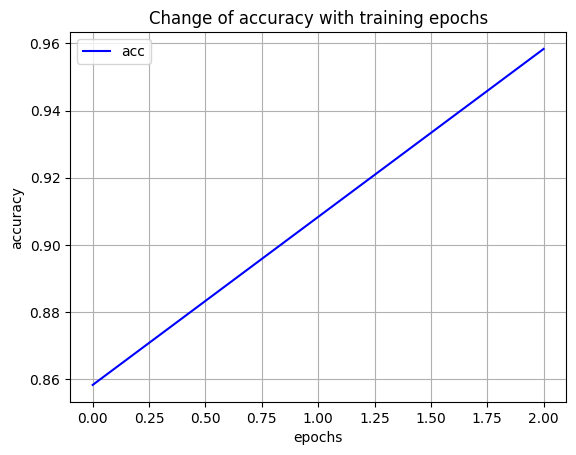

神经网络模型准确度分析：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         6

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [10]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# author: 徐聪
# datetime: 2022-10-23 11:35
# software: PyCharm

import numpy as np
import scipy.special as ssp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


class BPNet:
    def __init__(self, input_num, hide_num, output_num):
        self.input_num = input_num
        self.hide_num = hide_num
        self.output_num = output_num

        # 激活函数
        self.active_fun = lambda x: ssp.expit(x)
        # 生成隐藏层以及输出层的权重矩阵，正态分布，期望为0，方差为hide_num的-0.5次方
        self.wih = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.hide_num, self.input_num))
        self.who = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.output_num, self.hide_num))

    def train(self, X, y, rate, epochs):
        """
        训练神经网络
        :param X: 样本特征
        :param y: 标签
        :param rate: 学习率
        :param epochs: 迭代次数
        :return:
        """
        # 生成隐藏层以及输出层的权重矩阵，正态分布，期望为0，方差为hide_num的-0.5次方
        self.wih = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.hide_num, self.input_num))
        self.who = np.random.normal(0.0, pow(self.hide_num, -0.5), (self.output_num, self.hide_num))

        # 训练样本数目
        num = X.shape[0]
        erro_list = []
        acc_list = []
        epoch_list = []

        # 神经网络模型的训练
        print("BP-NeuralNetwork training begins")
        for i in range(epochs):
            erro = 0
            # 遍历训练集中的数据
            for j in range(num):
                # 数据预处理
                data = X[j, :]
                label = np.ones(self.output_num) * 0.01
                label[y[j, 0]] = 0.99

                # 训练模型
                t = self.net_train(data, label, rate)
                erro += sum(t.T.dot(t)) / 3

            # if i % 50 == 0:
            print(f"epoch={i}, erro={(erro / num)[0]}, acc={self.getAcc(X, y)}")
            erro_list.append(erro / num)
            acc_list.append(self.getAcc(X, y))
            epoch_list.append(i)
            # print(f"训练迭代次数：{i + 1}")

        print("BP-NeuralNetwork training end")
        return erro_list, acc_list, epoch_list

    def getAcc(self, X, y):
        """
        获取模型的准确率
        :param X: 样本的特征矩阵
        :param y: 标签
        :return:
        """
        y_predict = self.query(X)
        cnt = 0
        for i in range(y.shape[0]):
            if y_predict[i, 0] == y[i, 0]:
                cnt += 1
        return cnt / y.shape[0]

    def net_train(self, X, y, rate):
        """
        模型训练
        :param rate: 学习率
        :param X: 特征
        :param y: 标签
        :return:
        """

        # 数据初始化
        data = np.array(X, ndmin=2).T
        label = np.array(y, ndmin=2).T

        # 前向传播
        hide_z = self.wih.dot(data)
        hide_a = self.active_fun(hide_z)
        final_z = self.who.dot(hide_a)
        final_a = self.active_fun(final_z)

        # 反向传播
        final_error = label - final_a
        hide_error = self.who.T.dot(final_error)

        # 利用公式计算梯度
        final_gradient = np.dot((final_error * final_a * (1.0 - final_a)), np.transpose(hide_a))
        hide_gradient = np.dot((hide_error * hide_a * (1.0 - hide_a)), np.transpose(data))

        # 梯度下降更新权重矩阵  因为前面计算err时，是真实值-预测值，所以这里加梯度
        self.who += rate * final_gradient
        self.wih += rate * hide_gradient

        return final_error

    def query(self, X):
        """
        获取预测分类结果
        :param X: 样本特征
        :return:
        """

        num = X.shape[0]
        y_predict = [0] * num
        for i in range(num):
            y_predict[i] = np.argmax(self.net_query(X[i]))
            self.net_query(X[i])
        y_predict = np.array(y_predict).reshape((num, 1))
        return y_predict

    def net_query(self, X):
        """
        神经网络识别函数
        :param X: 需要识别的数据
        :return:
        """
        # 数据初始化
        data = np.array(X, ndmin=2).T

        # 前向传播计算
        hide_z = self.wih.dot(data)
        hide_a = self.active_fun(hide_z)
        final_z = self.who.dot(hide_a)
        final_a = self.active_fun(final_z)

        return final_a

data_path = r"iris_data.xls"

# 读取数据
df = pd.read_excel(data_path)
# 获取label
labels = list(set(df["species"]))
# 建立label到id的映射
id2label = {}
label2id = {}
cnt = 0
for label in labels:
    id2label[cnt] = label
    label2id[label] = cnt
    cnt += 1

# 将样本标签
y = [label2id[label] for label in list(df["species"])]
y = np.array(y).reshape((len(y), 1))
x = np.array(df.iloc[:, 0:4])

# 训练集和测试集切分
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 训练模型
bp = BPNet(4, 60, 3)
erro_list, acc_list, epoch_list= bp.train(x_train, y_train, 0.1, 3)

# 绘制图像
plt.figure(1)
plt.plot(epoch_list, erro_list, "r-", label="loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Change of loss function with training epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(1)
plt.plot(epoch_list, acc_list, "b-", label="acc")
plt.xlabel("epochs")
plt.title("Change of accuracy with training epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

# 模型准确性分析
print("神经网络模型准确度分析：")
print(classification_report(y_test, bp.query(x_test)))